In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from datetime import datetime
from collections import Counter
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from pathlib import Path
import pickle
import sys

import numpy as np
from monty.json import MSONable
from pymatgen.core.structure import Molecule

In [15]:
# https://gist.github.com/x94carbone/f5201b1c44963ff9453b9cc1d5f768ac
sys.path.append(str(Path.home() / Path("local")))
from mpl_utils import MPLAdjutant
adj = MPLAdjutant()
adj.set_defaults()

In [4]:
import json

def save_json(d, path):
    with open(path, 'w') as outfile:
        json.dump(d, outfile, indent=4, sort_keys=True)

def read_json(path):
    with open(path, 'r') as infile:
        dat = json.load(infile)
    return dat

Append the `home` path of this project.

In [5]:
sys.path.append(str(Path.cwd().parent))

# PCA

Load in the previously processed `pickle` data. These contain the features (ACSF) and targets (spectra) on a common grid for each of the three absorbing atom types of interest: C, N and O.

In [6]:
O_data = pickle.load(open("data/qm9/XANES-220622-ACSF-O.pkl", "rb"))
N_data = pickle.load(open("data/qm9/XANES-220622-ACSF-N.pkl", "rb"))
C_data = pickle.load(open("data/qm9/XANES-220622-ACSF-C.pkl", "rb"))

Print some diagonstics...

In [8]:
print(f"O database ACSF & spectrum shapes: {O_data['x'].shape} & {O_data['y'].shape}")
print(f"N database ACSF & spectrum shapes: {N_data['x'].shape} & {N_data['y'].shape}")
print(f"C database ACSF & spectrum shapes: {C_data['x'].shape} & {C_data['y'].shape}")

O database ACSF & spectrum shapes: (186813, 155) & (186813, 200)
N database ACSF & spectrum shapes: (139058, 155) & (139058, 200)
C database ACSF & spectrum shapes: (841912, 155) & (841912, 200)


Put everything in a dictionary for simplicity.

In [9]:
data = {"O": O_data, "N": N_data, "C": C_data}

Load in the FEFF failure example.

## Execute and plot

We perform basic analysis and Principal Component Analysis to validate that our dataset look sensible.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_results = dict()
for key, dat in data.items():
    pca_acsf = PCA(2)
    w_acsf = pca_acsf.fit_transform(dat["x"])
    pca_spectra = PCA(2)
    w_spectra = pca_spectra.fit_transform(dat["y"])
    pca_results[key] = {
        "pca_ACSF": pca_acsf,
        "pca_spectra": pca_spectra,
        "w_ACSF": w_acsf,
        "w_spectra": w_spectra
    }

We make a production-quality plot of the data here:

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2))

N = None
key_ordering = ["C", "N", "O"]

for key, ax in zip(key_ordering, axs):
    w_acsf = pca_results[key]["w_ACSF"]
    w_spectra = pca_results[key]["w_spectra"]
    ax.scatter(w_acsf[:N, 0], w_acsf[:N, 1], alpha=0.02, c=w_spectra[:N, 0], s=1, cmap="rainbow", rasterized=True)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(key)

axs[0].set_ylabel(r"ACSF $z_2$")
axs[1].set_xlabel(r"ACSF $z_1$")
    
# plt.savefig("Figures/qm9_pca.svg", bbox_inches="tight", dpi=300)
plt.show()

# Train/validation-test split

In [11]:
from xas_nne.qm9 import remove_zwitter_ions_, random_split, split_qm9_data_by_number_of_total_atoms, split_qm9_data_by_number_of_absorbers, atom_count

In [ ]:
def pca_decomposition_inputs(data, max_pca=50, capture_variance=0.999):
    data = deepcopy(data)
    pca = PCA(max_pca)
    pca.fit(data["train"]["x"])
    max_column = np.where(np.cumsum(pca.explained_variance_ratio_) > capture_variance)[0][0]
    print(f"maxcol={max_column}")
    for key in ["train", "val", "test"]:
        data[key]["x"] = pca.transform(data[key]["x"])[:, :max_column+1]
    data["pca"] = pca
    return data, max_column

## Remove Zwitter ions

In [ ]:
for CENTRAL_ATOM in ["C", "N", "O"]:
    print(f"{CENTRAL_ATOM} original length {len(data[CENTRAL_ATOM]['x'])}")
    remove_zwitter_ions_(data[CENTRAL_ATOM])

## Random split

In [ ]:
for CENTRAL_ATOM in ["C", "N", "O"]:
    prop = 0.1 if CENTRAL_ATOM != "C" else 0.05
    parsed_data = random_split(data[CENTRAL_ATOM], prop_test=prop, prop_val=prop)
    now = datetime.now().strftime("%y%m%d")
    fname = f"data/qm9/ml_ready/random_splits/XANES-{now}-ACSF-{CENTRAL_ATOM}-RANDOM-SPLITS.pkl"
    pickle.dump(parsed_data, open(fname, "wb"), protocol=pickle.HIGHEST_PROTOCOL)
    
    parsed_data, max_column = pca_decomposition_inputs(parsed_data)
    fname = f"data/qm9/ml_ready/random_splits/XANES-{now}-ACSF-{CENTRAL_ATOM}-RANDOM-SPLITS-PCA-decomp-maxcol-{max_column}.pkl"
    pickle.dump(parsed_data, open(fname, "wb"), protocol=pickle.HIGHEST_PROTOCOL)

Reload and retest. Ensure there are no zwitterions...

In [ ]:
for file in Path("data/qm9/ml_ready/random_splits/").iterdir():
    loaded = pickle.load(open(file, "rb"))
    for split in ["test", "train", "val"]:
        assert np.sum(["+" in smi for smi in loaded[split]["origin_smiles"]]) == 0
        assert np.sum(["-" in smi for smi in loaded[split]["origin_smiles"]]) == 0

## Train on molecules with at most `N` atoms

Get a production-quality plot for demonstrating how the database scales with atom number/molecule.

In [12]:
atom_counts_sorted = dict()

int_grid = np.arange(1, 10)

ATOM = "C"
tmp_data = data[ATOM]
atom_counts = list(map(atom_count, tmp_data["origin_smiles"]))
atom_counts = np.array([sum(xx.values()) for xx in atom_counts])
atom_counts_counter = Counter(atom_counts)
atom_counts_sorted["C"] = [atom_counts_counter[ii] for ii in int_grid]

ATOM = "N"
tmp_data = data[ATOM]
atom_counts = list(map(atom_count, tmp_data["origin_smiles"]))
atom_counts = np.array([sum(xx.values()) for xx in atom_counts])
atom_counts_counter = Counter(atom_counts)
atom_counts_sorted["N"] = [atom_counts_counter[ii] for ii in int_grid]

ATOM = "O"
tmp_data = data[ATOM]
atom_counts = list(map(atom_count, tmp_data["origin_smiles"]))
atom_counts = np.array([sum(xx.values()) for xx in atom_counts])
atom_counts_counter = Counter(atom_counts)
atom_counts_sorted["O"] = [atom_counts_counter[ii] for ii in int_grid]

In [20]:
from matplotlib.ticker import AutoMinorLocator

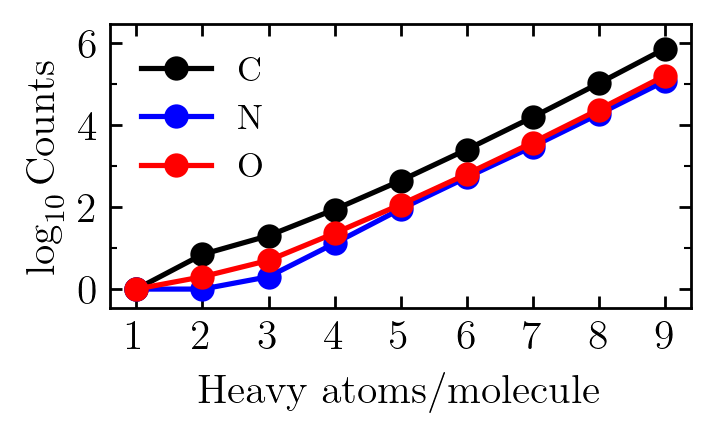

In [23]:
# Create a well-balanced testing set
fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))


ax.plot(int_grid, np.log10(atom_counts_sorted["C"]), 'ko-', label=r"C")
ax.plot(int_grid, np.log10(atom_counts_sorted["N"]), 'bo-', label=r"N")
ax.plot(int_grid, np.log10(atom_counts_sorted["O"]), 'ro-', label=r"O")


adj.set_grids(ax, grid=False)
ax.set_xticks(int_grid)
ax.tick_params(axis="x", which="minor", bottom=False, top=False)
ax.tick_params(axis="y", which="minor", left=True, right=True)

ax.set_ylabel(r"$\log_{10} \mathrm{Counts}$")
ax.set_xlabel(r"Heavy atoms/molecule")

ax.legend(frameon=False)

ax.set_yticks([0, 2, 4, 6])

minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)

adj.set_ylim(ax, 0, 6)


plt.savefig("Figures/qm9_N-2.svg", bbox_inches="tight", dpi=300)
# plt.show()

In [ ]:
for max_training_atoms_per_molecule in range(5, 9):
    for CENTRAL_ATOM in ["C", "N", "O"]:
        print(CENTRAL_ATOM)
        parsed_data = split_qm9_data_by_number_of_total_atoms(
            data[CENTRAL_ATOM],
            max_training_atoms_per_molecule=max_training_atoms_per_molecule,
            test_atoms_per_molecule=9,
            prop_val=0.1,
            seed=123
        )
        now = datetime.now().strftime("%y%m%d")
        fname = f"data/qm9/ml_ready/XANES-{now}-ACSF-{CENTRAL_ATOM}-TRAIN-ATMOST-{max_training_atoms_per_molecule}-TOTAL-ATOMS.pkl"
        print(fname)
        pickle.dump(parsed_data, open(fname, "wb"), protocol=pickle.HIGHEST_PROTOCOL)

        parsed_data, max_column = pca_decomposition_inputs(parsed_data)
        fname = f"data/qm9/ml_ready/XANES-{now}-ACSF-{CENTRAL_ATOM}-TRAIN-ATMOST-{max_training_atoms_per_molecule}-TOTAL-ATOMS-PCA-decomp-maxcol-{max_column}.pkl"
        print(fname)
        pickle.dump(parsed_data, open(fname, "wb"), protocol=pickle.HIGHEST_PROTOCOL)

Reload and retest. Ensure there are no zwitterions...

In [ ]:
for file in Path("data/qm9/ml_ready/by_total_atoms/").iterdir():
    loaded = pickle.load(open(file, "rb"))
    for split in ["test", "train", "val"]:
        assert np.sum(["+" in smi for smi in loaded[split]["origin_smiles"]]) == 0
        assert np.sum(["-" in smi for smi in loaded[split]["origin_smiles"]]) == 0